In [1]:
import os
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'
import subprocess
subprocess.run(['pip', 'install', 'sklearn'])

CompletedProcess(args=['pip', 'install', 'sklearn'], returncode=0)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
import pandas as pd
import numpy as np
import fastparquet as fp
import time
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import jax
import tensorflow as tf
keras.utils.set_random_seed(1)

In [3]:
from sigtkan_manual import SigTKAN
from tkan import TKAN

In [4]:
df = pd.read_parquet('data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
df = df.head(500)
display(df)

,BTC,ADA,XMR,EOS,CHZ,MATIC,TRX,ENJ,FTM,BNB,XLM,BUSD,ATOM,LTC,LINK,ETC,ETH,XRP,BCH
group,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,3.675857e+06,38189.176211,45395.983051,9.477858e+04,817.146319,31003.791035,481993.354990,15241.945783,1165.788613,8.498617e+05,9460.819556,1.352376e+04,31986.972694,1.165827e+05,2.428117e+04,5.648840e+04,1.000930e+06,2.579254e+05,1.782587e+05
2020-01-01 01:00:00,6.365953e+06,51357.010954,33483.951528,5.932921e+05,886.460339,84465.335718,533668.554562,11896.843688,413.844612,7.405759e+05,37141.909518,2.531605e+04,81777.666046,2.830715e+05,5.119098e+04,1.821021e+05,1.474278e+06,4.520609e+05,6.153210e+05
2020-01-01 02:00:00,4.736719e+06,36164.263914,15732.553860,2.667326e+05,1819.795050,113379.718506,387049.986770,30109.770521,3559.965968,1.039091e+06,16878.822627,1.390886e+04,195731.175551,2.402871e+05,2.872176e+04,1.340634e+05,9.940256e+05,4.414948e+05,2.215356e+05
2020-01-01 03:00:00,5.667367e+06,24449.953815,25751.054662,1.245166e+05,2979.655803,41771.707995,450772.139235,6732.833578,4076.415482,4.975018e+05,9049.223394,2.251969e+04,120113.343316,1.613043e+05,2.959622e+04,1.310942e+05,6.473610e+05,1.886061e+05,3.971860e+05
2020-01-01 04:00:00,3.379094e+06,44502.669843,62955.628253,4.218197e+05,1023.388675,22254.756114,284788.973752,846.938455,633.367505,4.751285e+05,7254.260203,1.122460e+04,19989.169106,2.214516e+05,5.451437e+04,1.349371e+05,4.430067e+05,2.279373e+05,3.164991e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21 15:00:00,1.255210e+07,470590.372121,42760.927068,7.453124e+05,13246.215433,194642.829145,350917.288805,11395.449868,3316.339995,1.924501e+06,413944.202762,5.766766e+05,136528.213153,5.953967e+05,2.351074e+05,1.635402e+06,1.511907e+06,9.031691e+05,1.614753e+06
2020-01-21 16:00:00,1.343373e+07,961845.809967,113709.479837,1.269031e+06,3692.115542,359433.587696,422347.988487,5052.336237,8456.993069,1.306569e+06,830123.292453,3.433625e+05,224934.146373,9.369866e+05,4.863213e+05,2.595147e+06,3.791875e+06,1.689575e+06,2.933687e+06
2020-01-21 17:00:00,8.343923e+06,343709.850786,42191.566063,4.855322e+05,42834.106271,136314.391155,351140.663827,5293.137970,11741.040433,1.065739e+06,347330.782839,1.534735e+05,563745.606195,2.516371e+05,3.994359e+05,6.810294e+05,1.449803e+06,6.444043e+05,8.640450e+05


In [5]:
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initialize the MinMaxScaler.
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # Default range for scaling (min, max)

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data.
        """
        X_scaled = (X - self.min_) / self.scale_
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original data scale.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

def generate_data(df, sequence_length, n_ahead = 1):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

In [ ]:
early_stopping_callback = lambda : tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,    
    patience=6,         
    mode="min",
    restore_best_weights=True,
    start_from_epoch=3, 
    verbose=1,
)

lr_callback = lambda : tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    mode="min",
    min_delta=0.0001,  
    min_lr=0.000025,
    verbose=1,
)

callbacks = lambda : [early_stopping_callback(), lr_callback(), tf.keras.callbacks.TerminateOnNaN()]

: 

In [ ]:
def tkan_config(return_sequences):
    return {
        "units": 100,
        "dropout": 0.0,
        "sub_kan_output_dim": 20,
        "sub_kan_input_dim": 20,
        "return_sequences": return_sequences
    }

n_aheads = [1]
models = ["TKAN", "SigTKAN"]
N_MAX_EPOCHS = 1000
BATCH_SIZE = 128

callbacks = lambda : [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    tf.keras.callbacks.TerminateOnNaN()
]

results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_rmse = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
time_results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
all_errors = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}

for n_ahead in n_aheads:
    sequence_length = max(45, 5 * n_ahead)
    X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)
    
    for model_id in models:
        for run in range(10):
            if model_id == 'TKAN':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    TKAN(**tkan_config(return_sequences=True)),
                    TKAN(**tkan_config(return_sequences=False)),
                    Dense(units=n_ahead, activation='linear')
                ], name=model_id)

            elif model_id == 'SigTKAN':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    SigTKAN(sig_level=2, **tkan_config(return_sequences=True)),
                    SigTKAN(sig_level=2, **tkan_config(return_sequences=False)),
                    Dense(units=n_ahead, activation='linear')
                ], name=model_id)

            else:
                raise ValueError(f"Unknown model_id: {model_id}")

            optimizer = tf.keras.optimizers.Adam(0.0001)
            model.compile(optimizer=optimizer, loss='mean_squared_error', jit_compile=True)
            if run == 0:
                model.summary()

            start_time = time.time()
            history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose=False)
            end_time = time.time()
            time_results[model_id][n_ahead].append(end_time - start_time)

            preds = model.predict(X_test, verbose=False)
            r2 = r2_score(y_true=y_test, y_pred=preds)
            rmse = np.sqrt(np.mean((y_test - preds) ** 2))
            
            errors = preds - y_test
            all_errors[model_id][n_ahead].append(errors)

            print(end_time - start_time, r2)

            results[model_id][n_ahead].append(r2)
            results_rmse[model_id][n_ahead].append(rmse)

            del model
            del optimizer


print('R2 scores - Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results}))

print('RMSE scores - Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse}))

print('R2 scores - Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results}))

print('RMSE scores - Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse}))

print('Training Times - Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results}))

print('Training Times - Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results}))

Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan (TKAN)                     │ (None, 45, 100)        │        41,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_1 (TKAN)                   │ (None, 100)            │        67,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,981 (429.61 KB)

 Trainable params: 109,581 (428.05 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 32: early stopping
18.846561908721924 -0.10719409345978281
Epoch 15: early stopping
12.009342432022095 -0.11455709706362804
Epoch 8: early stopping
10.390624761581421 -8.517273963767057
Epoch 6: early stopping
10.512553215026855 -2.005832781393044
Epoch 14: early stopping
12.50280475616455 -0.18755474105340197
Epoch 4: early stopping
10.382871866226196 -6.479782882479294
Epoch 9: early stopping
10.658963441848755 -7.374046037513969
Epoch 33: early stopping
19.087714672088623 -1.8811576110244665
Epoch 4: early stopping
10.430915832519531 -10.042124990305703
Epoch 15: early stopping
15.086054563522339 -0.34741692713630057


Model: "SigTKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sig_tkan (SigTKAN)              │ (None, 45, 100)        │        75,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sig_tkan_1 (SigTKAN)            │ (None, 100)            │       109,945 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,971 (726.45 KB)

 Trainable params: 185,571 (724.89 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 129: early stopping
872.0335099697113 -0.17003286619235136


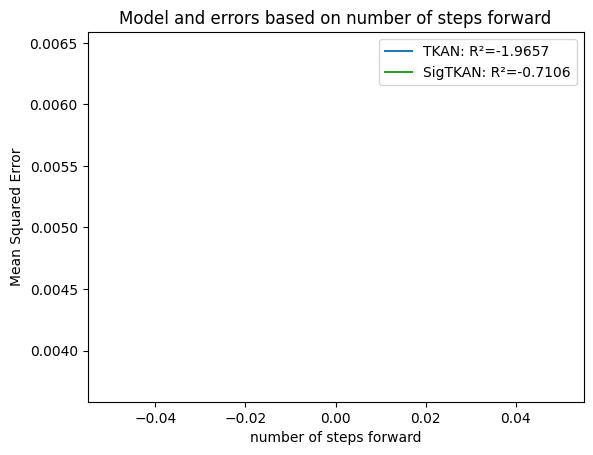

In [ ]:
# Préparer all_errors pour le plot
all_errors_plot = {}
all_errors_plot['TKAN'] = np.mean(all_errors['TKAN'][1], axis=0)
all_errors_plot['SigTKAN'] = np.mean(all_errors['SigTKAN'][1], axis=0)    

model_types = ['TKAN', 'SigTKAN']
colors = ['#1f77b4', '#2ca02c'] 

for model_type, color in zip(model_types, colors):
    y_pred = all_errors_plot[model_type] + y_test
    r2 = r2_score(y_true=y_test.flatten(), y_pred=y_pred.flatten())
    plt.plot(np.mean(all_errors_plot[model_type]**2, axis=0), label=f'{model_type}: R²={round(r2,4)}', color=color)

plt.legend()
plt.title('Model and errors based on number of steps forward')
plt.xlabel('number of steps forward')
plt.ylabel('Mean Squared Error')
plt.show()